In [1]:
#!/usr/bin/env python
"""choose_skies.ipynb: a notebook to choose detectable skies """

__author__ = "Chiara M. F. Mingarelli"
__copyright__ = "Copyright 2016, GWASAP project"
__credits__ = ["Chiara Mingarelli", "Stephen Taylor"]
__license__ = "GPL"
__version__ = "0.0.1"
__maintainer__ = "Chiara Mingarelli"
__email__ = "mingarelli@gmail.com"
__status__ = "prototype"

In [ ]:
"""
This plots the average anisotropy for the 3 different relations
"""

In [2]:
from __future__ import division
import os
from IPython.display import display, Math, Latex
import math
from math import sqrt, cos, sin, pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from matplotlib.ticker import FormatStrFormatter, LinearLocator, NullFormatter, NullLocator, MultipleLocator
import matplotlib.ticker
import matplotlib.colors
from matplotlib.font_manager import FontProperties
from matplotlib import rc, text
import healpy as hp
import plot_mpl2 as plot
from astropy.io import fits

import AnisCoefficients_pix as cbylm_pix

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [17]:
# plotting preamble

fig_width_pt = 245.27 #513.17           # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

params = {'backend': 'pdf',
        'axes.labelsize': 7,
        'lines.markersize': 2,
        'font.size': 7,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.0,
        'legend.fontsize': 7,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        #'axes.color_cycle': ['b', 'lime', 'r', 'purple', 'g', 'c', 'm', 'orange', 'darkblue', \
        #                        'darkcyan', 'y','orangered','chartreuse','brown','deeppink','lightgreen', 'k'],
        #'font.serif':cm,
        'figure.figsize': fig_size}
plt.rcParams.update(params)

In [3]:
nside = 2**6
#freq_choice = np.loadtxt("gw_freqs.dat") #available GW frequencies

In [9]:
#constant
T_tot = 20
lmax = 50


In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def hist_weight(lst):
    return np.ones_like(lst)/len(lst)

def auto_bin(bin_size, min_edge, max_edge):
    #bin_size = 0.05; min_edge = -3.5; max_edge = -1
    N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
    bin_list = np.linspace(min_edge, max_edge, Nplus1)
    return bin_list

def h2_c(hk, fk, deltaF):
    """
    Eq 35 Babak et al. 2016; 
    Given a sky of strains at certain frequencies,
    what is it in terms of a GW background?
    returns h^2_c
    """
    h2k = np.square(hk)
    ans = h2k*fk/deltaF
    return ans


def pol2cart(lon, lat): 
    """ 
    Utility function to convert longitude,latitude on a unit sphere to 
    cartesian co-ordinates.

    """ 

    x = np.cos(lat)*np.cos(lon) 
    y = np.cos(lat)*np.sin(lon) 
    z = np.sin(lat) 

    return np.array([x,y,z])


def greedy_bin_sky(skypos, skycarts, weights=None):
    """

    Greedy binning algorithm

    """

    N = len(skycarts) 
    skycarts = np.array(skycarts)
    bins = np.zeros(N)
    ct = 0
    for raSample, decSample in skypos: 
        sampcart = pol2cart(raSample, decSample) 
        dx = np.dot(skycarts, sampcart)
        maxdx = np.argmax(dx)

        if weights is not None:
            bins[maxdx] += weights[ct]
        else:
            bins[maxdx] += 1

        ct += 1

    # fill in skymap
    histIndices = np.argsort(bins)[::-1]    # in decreasing order
    NSamples = len(skypos)

    frac = 0.0
    skymap = np.zeros(N)
    for i in histIndices:
        frac = float(bins[i]) # /float(NSamples) 
        skymap[i] = frac

    return skymap


def plotSkyMap(raSample, decSample, nside=64, contours=None, colorbar=True, \
              inj=None, weights=None, psrs=None):
    """

    Plot Skymap of chain samples on Mollwiede projection.

    @param raSample: Array of right ascension samples
    @param decSample: Array of declination  samples
    @param nside: Number of pixels across equator [default = 64]
    @param contours: Confidence contours to draw eg. 68%, 95% etc
                     By default this is set to none and no contours
                     will be drawn.
    @param colorbar: Boolean option to draw colorbar [default = True]
    @param inj: list of injected values [ra, dec] in radians to plot
                [default = None]
    @param weights: sample weights [default = None]
    @param psrs: Stacked array of pulsar sky locations [ra, dec] in radians
                 [default=None] Will plot as white diamonds

    """

    # clear figures
    plt.clf()

    # create stacked array of ra and dec
    skypos = np.column_stack([raSample, decSample])

    npix = hp.nside2npix(nside)    # number of pixels total


    # initialize theta and phi map coordinantes
    skycarts=[]
    for ii in range(npix):
        skycarts.append(np.array(hp.pix2vec(nside,ii)))

    # get skymap values from greedy binning algorithm
    skymap = greedy_bin_sky(skypos, skycarts, weights)

    # smooth skymap
    #skymap = hp.smoothing(skymap, 0.1)

    # make plot
    ax = plt.subplot(111, projection='astro mollweide')

    # plot map
    ax.grid()
    plot.outline_text(ax)
    plot.healpix_heatmap(skymap, cmap = 'viridis')

    return skymap
    # save skymap
    #plt.savefig('skymap.pdf', bbox_inches='tight')
    
def make_Cls(T_tot, strain_vec, RA, DEC, freq, lmax, jj):
    T = T_tot*31556952# years in seconds, consistent with EPTA data
    dF = 1/T
    hc_strain = np.sqrt(h2_c(strain_vec, freq, dF))
    hpskymap = plotSkyMap(RA, DEC , weights = hc_strain)
    alm_map = hp.map2alm(hpskymap,lmax)
    hpskymap_lmax = hp.alm2map(alm_map,nside=128)
    hpskymap_lmax[hpskymap_lmax < 0.0] = 0.0
    # h^2_c for C_l decomposition
    hpskymap2 = plotSkyMap(RA, DEC, weights = hc_strain**2)
    # create alm map form healpix map
    alm_map2 = hp.map2alm(hpskymap2,lmax)
    # make a map in terms of \ell from the alm map
    hpskymap_lmax2 = hp.alm2map(alm_map2,nside=128)
    ## Decompose this onto real spherical harmonics with our standard normalisations
    clm = cbylm_pix.clmFromMap_fast(hpskymap2, lmax)
    # Make the angular power spectrum, Cl = \sum_m |clm|^2 / (2l+1)
    Cl_all = np.zeros(lmax+1)
    for ll in range(0,lmax+1):
        Cl_all[ll] = np.sum(clm[ll**2:(ll+1)**2]**2.0) / (2.0*ll+1.0) / (4.0*pi)
    # write Cls to file
    #np.savetxt("Cl_data/Cl_test"+str(jj)+".txt", Cl_all)
    return Cl_all


In [ ]:
def make_ani_vec(filepath):
    
    ani_vec = []
    
    file_s = [] #numbers of sources per relaization
    RA = []
    DEC = []
    freq = []
    strain = []

    #temps used to help seperate data by relalization
    temp_RA = []
    temp_DEC = []
    temp_freq = []
    temp_strain = []
    temp_file_s = []

    with open(data_filename) as f:

        temp_RA = []
        temp_DEC = []
        temp_freq = []
        temp_strain = []
        temp_file_s = []

        for line in f:
            if len(line) < 50:

                #add the collected data to the real lists

                file_s.append(count)
                RA.append(temp_RA) #phi, add pi to this for healpix maps
                DEC.append(temp_DEC) #theta
                freq.append(temp_freq)
                strain.append(temp_strain)

                #reset the temp lists

                temp_RA = []
                temp_DEC = []
                temp_freq = []
                temp_strain = []
                temp_z = []
                temp_file_s = []
                count = 0

            else:

                #data is split into its corresponding lists

                splitted = line.split(" ") 
                
                temp_RA.append(float(splitted[0])) #phi, add pi to this for healpix maps
                temp_DEC.append(float(splitted[1])) #theta
                temp_freq.append(float(splitted[2]))
                temp_strain.append(float(splitted[3]))
                count+=1


    #adding final realization
    file_s.append(count)
    RA.append(temp_RA) #phi, add pi to this for healpix maps
    DEC.append(temp_DEC) #theta
    freq.append(temp_freq)
    strain.append(temp_strain)


    #deleting intial empty array ex) stall = [[], [2], [3]] --> [[2], [3]]
    file_s = file_s[1:]
    RA = RA[1:]
    DEC = DEC[1:]
    freq = freq[1:]
    strain = strain[1:]
    
    for (int i = 0; i < len(file_s); i++):
        ani_vec.append(make_Cls(T_tot, strain[i], RA[i], DEC[i], freq[i], lmax, i))
        
    
    
    return ani_vec


In [5]:
#MM13 0.34 files
mmfiles = []
for i in os.listdir('../../rusty_data/MM13_Reg/34_dex/'):
    if i.endswith('.txt'):
        mmfiles.append(i)

In [6]:
len(mmfiles)

116150

In [9]:
#MM13 0.51 files
mmfiles51 = []
for i in os.listdir('../../rusty_data/MM13_Reg/51_dex/'):
    if i.endswith('.txt'):
        mmfiles51.append(i)

In [10]:
#MM13 0.68 files
mmfiles68 = []
for i in os.listdir('../../rusty_data/MM13_Reg/68_dex/'):
    if i.endswith('.txt'):
        mmfiles68.append(i)

In [11]:
#MM13 1.02 files
mmfiles102 = []
for i in os.listdir('../../rusty_data/MM13_Reg/102_dex/'):
    if i.endswith('.txt'):
        mmfiles102.append(i)

In [12]:
len(mmfiles102)

110422

In [7]:
#KH13 files
khfiles29 = []
for i in os.listdir('../../rusty_data/KH13_Reg/29_dex/'):
    if i.endswith('.txt'):
        khfiles29.append(i)

In [5]:
#KH13 files
khfiles435 = []
for i in os.listdir('../../rusty_data/KH13_Reg/435_dex/'):
    if i.endswith('.txt'):
        khfiles435.append(i)

In [6]:
#KH13 files
khfiles58 = []
for i in os.listdir('../../rusty_data/KH13_Reg/58_dex/'):
    if i.endswith('.txt'):
        khfiles58.append(i)

In [7]:
#KH13 files
khfiles87 = []
for i in os.listdir('../../rusty_data/KH13_Reg/87_dex/'):
    if i.endswith('.txt'):
        khfiles87.append(i)

In [8]:
#HR04 files
hrfiles = []
for i in os.listdir('../../rusty_data/HR04_Reg/30_dex/'):
    if i.endswith('.txt'):
        hrfiles.append(i)

In [8]:
mm_sig_files = []
for i in os.listdir('../../test_data/sigma_test/MM13_Reg/'):
    if i.endswith('1'):
        mm_sig_files.append(i)

In [9]:
kh_sig_files = []
for i in os.listdir('../../test_data/sigma_test/KH13_Reg/'):
    if i.endswith('1'):
        kh_sig_files.append(i)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

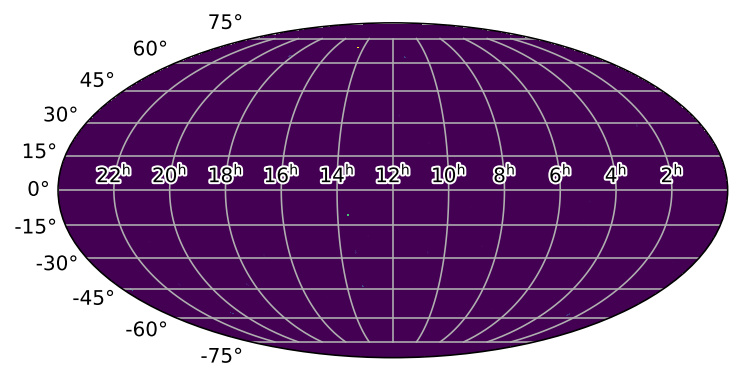

In [10]:
#MM13 data
mm_ani_vec = []
for jj in range(lmax):
    filename = mmfiles[jj]
    sim_sky = np.genfromtxt("../../rusty_data/MM13_Reg/34_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    mm_ani_vec.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

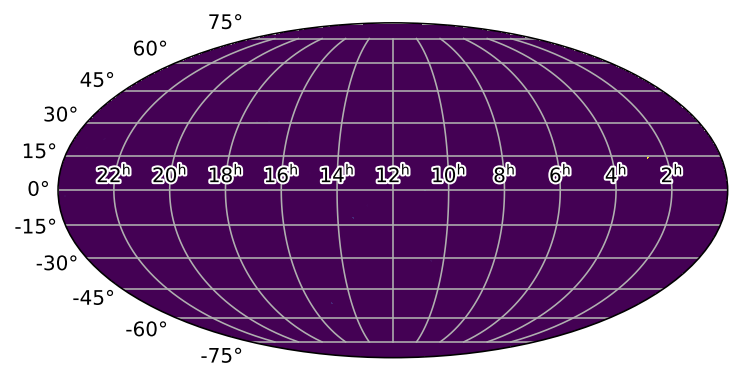

In [15]:
#MM13 data for 0.51 dex
mm_ani_vec_51 = []
for jj in range(50):
    filename = mmfiles51[jj]
    sim_sky = np.genfromtxt("../../rusty_data/MM13_Reg/51_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    mm_ani_vec_51.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

In [16]:
#MM13 data for 0.68 dex
mm_ani_vec_68 = []
for jj in range(50):
    filename = mmfiles68[jj]
    sim_sky = np.genfromtxt("../../rusty_data/MM13_Reg/68_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    mm_ani_vec_68.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

OSError: ../rusty_data/MM13_Reg/68_dex/mm13_68_126394.txt not found.

In [ ]:
#MM13 data for 1.02 dex
mm_ani_vec_102 = []
for jj in range(50):
    filename = mmfiles102[jj]
    sim_sky = np.genfromtxt("../../rusty_data/MM13_Reg/102_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    
    mm_ani_vec_102.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))
    
    
    
    
    
    

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

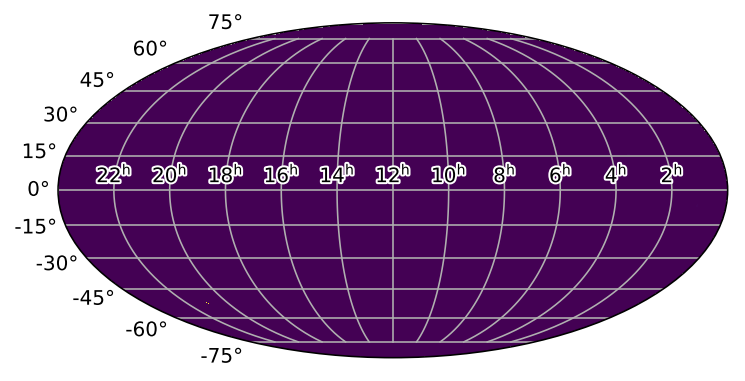

In [11]:
#KH13 data
kh_ani_vec29 = []
for jj in range(50):
    filename = khfiles29[jj]
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg/29_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    kh_ani_vec29.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

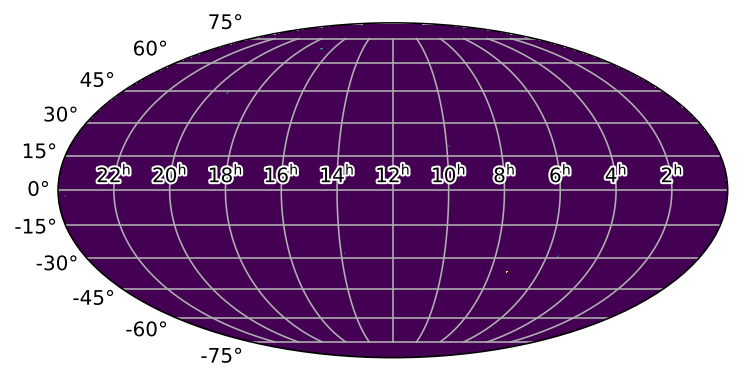

In [14]:
#KH13 data
kh_ani_vec435 = []
for jj in range(50):
    filename = khfiles435[jj]
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg/435_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    kh_ani_vec435.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

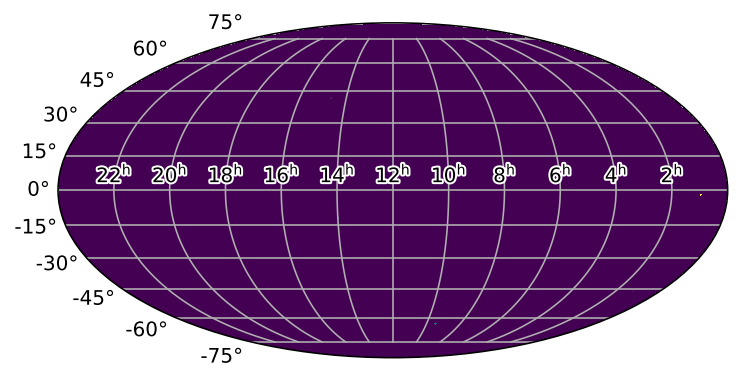

In [15]:
#KH13 data
kh_ani_vec58 = []
for jj in range(50):
    filename = khfiles58[jj]
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg/58_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    kh_ani_vec58.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

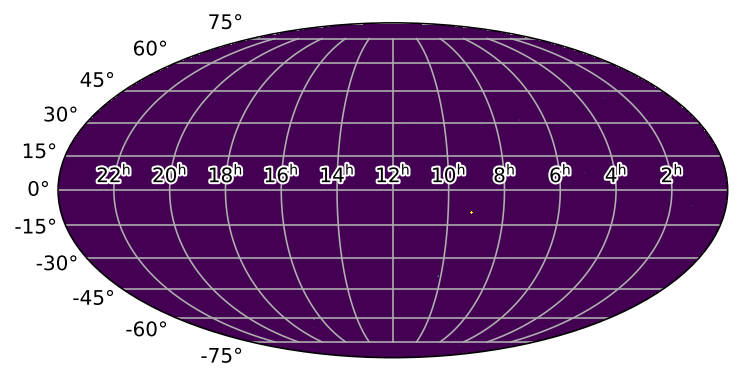

In [16]:
#KH13 data
kh_ani_vec87 = []
for jj in range(50):
    filename = khfiles87[jj]
    sim_sky = np.genfromtxt("../../rusty_data/KH13_Reg/87_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    kh_ani_vec87.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

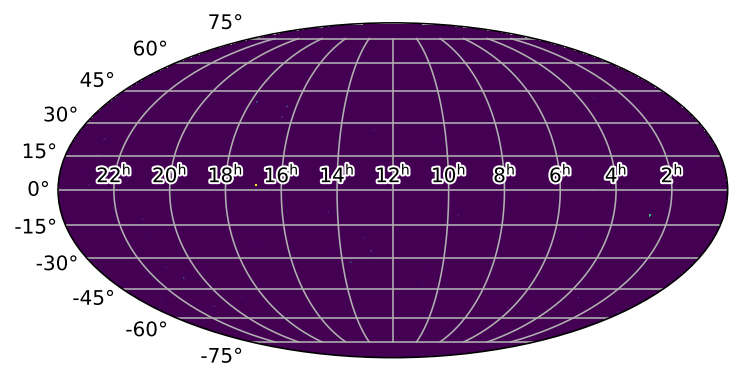

In [12]:
#HR04 data
hr_ani_vec = []
for jj in range(50):
    filename = hrfiles[jj]
    sim_sky = np.genfromtxt("../../rusty_data/HR04_Reg/30_dex/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    hr_ani_vec.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

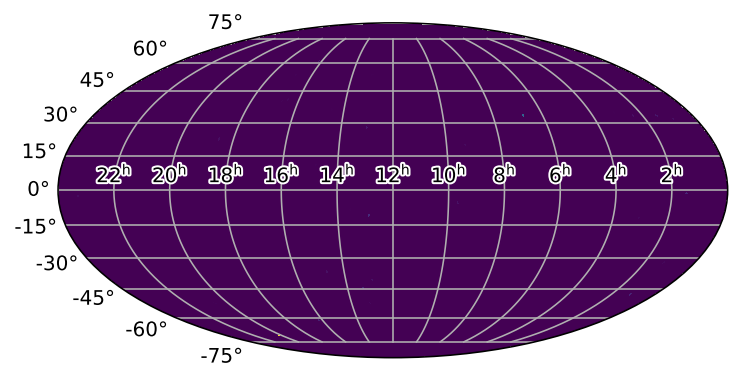

In [17]:
#MM13_SIG
mm_sig_ani_vec = []
for jj in range(50):
    filename = mm_sig_files[jj]
    sim_sky = np.genfromtxt("../../test_data/sigma_test/MM13_Reg/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    mm_sig_ani_vec.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm

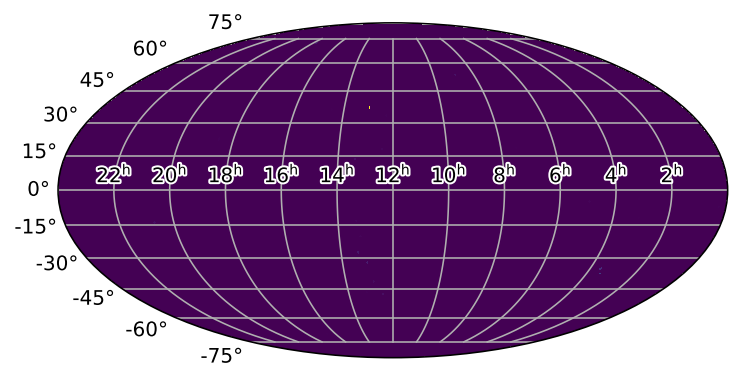

In [18]:
#MM13_SIG
kh_sig_ani_vec = []
for jj in range(50):
    filename = kh_sig_files[jj]
    sim_sky = np.genfromtxt("../../test_data/sigma_test/KH13_Reg/"+str(filename))
    RA_tot_noise = sim_sky[:,0] #phi, add pi to this for healpix maps
    DEC_tot_noise = sim_sky[:,1] #theta
    freq_noise = sim_sky[:,2]
    strain_vec_noise = sim_sky[:,3]
    file_size = strain_vec_noise.size # number of galaxies in file
    kh_sig_ani_vec.append(make_Cls(T_tot, strain_vec_noise, RA_tot_noise, DEC_tot_noise, freq_noise, lmax, jj))

Text(0,0.5,'$C_\\ell/C_0$')

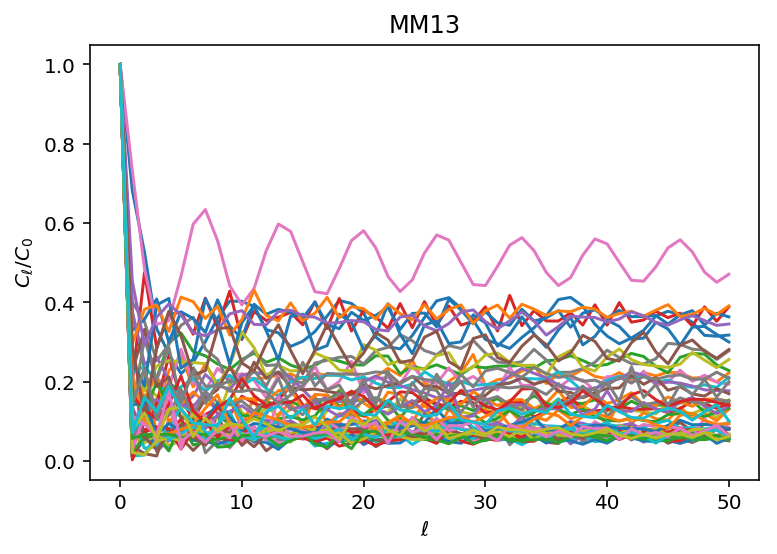

In [13]:
fig, ax = plt.subplots()
mm_store_ani = []
for i in range(len(mm_ani_vec)):
    Cl_all = mm_ani_vec[i]
    norm = Cl_all[0]
    mm_store_ani.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("plots_anisotropy/MM13_all_ani_curves_l50.pdf")

In [ ]:
fig, ax = plt.subplots()
mm_store_ani_51 = []
for i in range(len(mm_ani_vec_51)):
    Cl_all = mm_ani_vec_51[i]
    norm = Cl_all[0]
    mm_store_ani_51.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13 0.51 dex")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("../plots/MM13_51_all_ani_curves_l50.pdf")

In [ ]:
fig, ax = plt.subplots()
mm_store_ani_68 = []
for i in range(len(mm_ani_vec_68)):
    Cl_all = mm_ani_vec_68[i]
    norm = Cl_all[0]
    mm_store_ani_68.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13 0.68 dex")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("../plots/MM13_68_all_ani_curves_l50.pdf")

In [ ]:
fig, ax = plt.subplots()
mm_store_ani_102 = []
for i in range(len(mm_ani_vec_51)):
    Cl_all = mm_ani_vec_102[i]
    norm = Cl_all[0]
    mm_store_ani_102.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13 1.02 dex")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("../plots/MM13_102_all_ani_curves_l50.pdf")

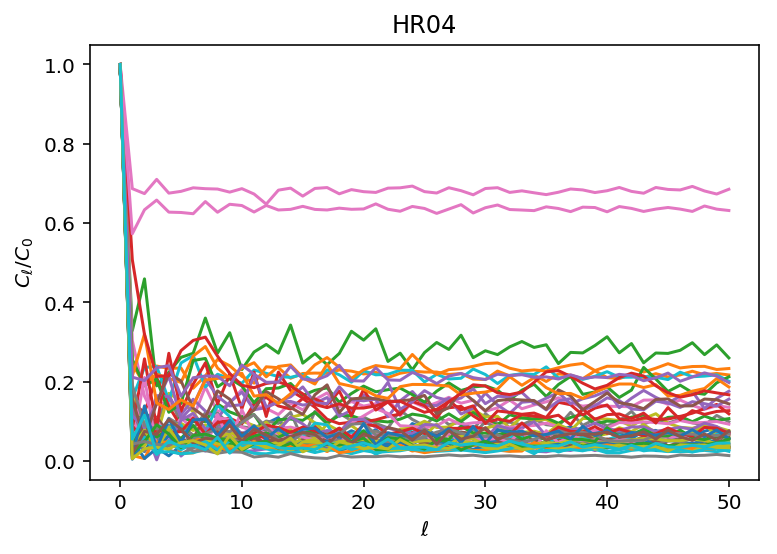

In [14]:
fig, ax = plt.subplots()
hr_store_ani = []
for i in range(len(hr_ani_vec)):
    Cl_all = hr_ani_vec[i]
    norm = Cl_all[0]
    hr_store_ani.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("HR04")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("plots_anisotropy/HR04_all_ani_curves_l50.pdf")

Text(0,0.5,'$C_\\ell/C_0$')

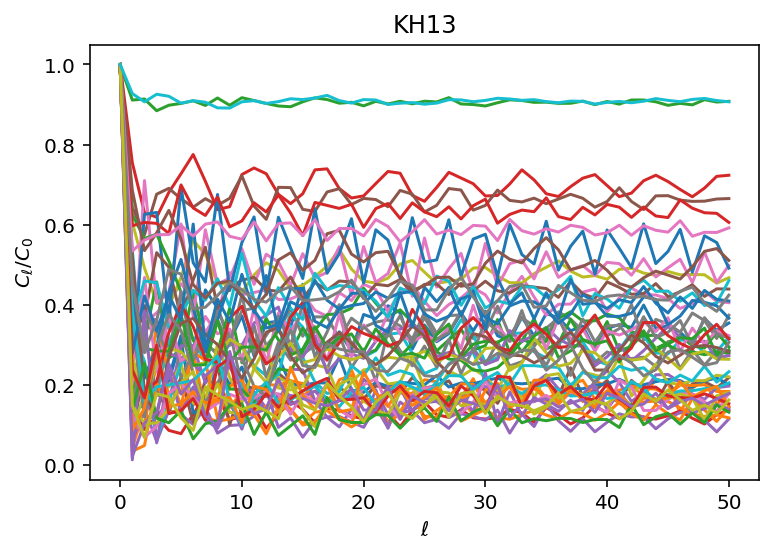

In [15]:
fig, ax = plt.subplots()
kh_store_ani29 = []
for i in range(len(kh_ani_vec29)):
    Cl_all = kh_ani_vec29[i]
    norm = Cl_all[0]
    kh_store_ani29.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("KH13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("plots_anisotropy/KH13_all_ani_curves_l50_29.pdf")

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


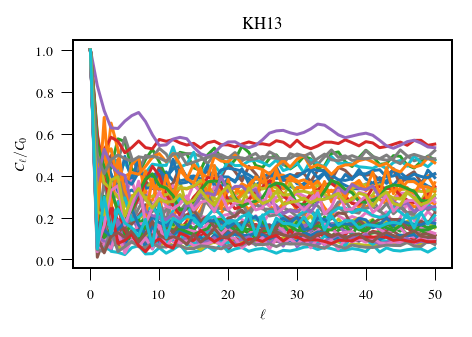

In [20]:
fig, ax = plt.subplots()
kh_store_ani435 = []
for i in range(len(kh_ani_vec435)):
    Cl_all = kh_ani_vec435[i]
    norm = Cl_all[0]
    kh_store_ani435.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("KH13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("plots_anisotropy/KH13_all_ani_curves_l50_435.pdf")

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


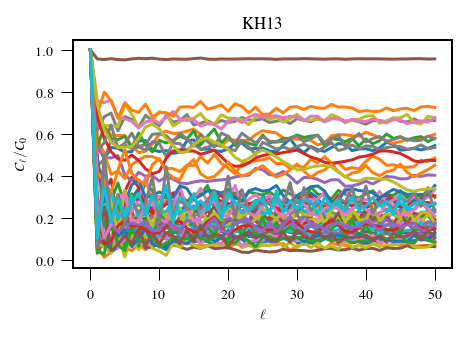

In [21]:
fig, ax = plt.subplots()
kh_store_ani58 = []
for i in range(len(kh_ani_vec58)):
    Cl_all = kh_ani_vec58[i]
    norm = Cl_all[0]
    kh_store_ani58.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("KH13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("plots_anisotropy/KH13_all_ani_curves_l50_58.pdf")

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


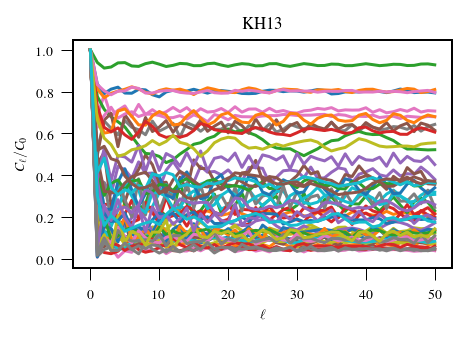

In [22]:
fig, ax = plt.subplots()
kh_store_ani87 = []
for i in range(len(kh_ani_vec87)):
    Cl_all = kh_ani_vec87[i]
    norm = Cl_all[0]
    kh_store_ani87.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("KH13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
plt.savefig("plots_anisotropy/KH13_all_ani_curves_l50_87.pdf")

[array([5.26003917e-67, 3.54927189e-67, 3.58134270e-67, 3.67965712e-67,
       3.61388174e-67, 3.87892459e-67, 3.59933089e-67, 3.74656871e-67,
       3.84261281e-67, 3.50693570e-67, 3.77417945e-67, 3.81351756e-67,
       3.67264223e-67, 3.73548473e-67, 3.57782509e-67, 3.78022548e-67,
       3.80907787e-67, 3.57566863e-67, 3.76977378e-67, 3.71286796e-67,
       3.68069261e-67, 3.82020176e-67, 3.65969370e-67, 3.72350880e-67,
       3.71026430e-67, 3.63430919e-67, 3.82514670e-67, 3.70903200e-67,
       3.66194219e-67, 3.75746713e-67, 3.65776581e-67, 3.75672756e-67,
       3.72180098e-67, 3.67169576e-67, 3.78284370e-67, 3.63698545e-67,
       3.70279590e-67, 3.78790564e-67, 3.65466614e-67, 3.74486635e-67,
       3.71670234e-67, 3.69616121e-67, 3.77484371e-67, 3.63919093e-67,
       3.71796593e-67, 3.76869614e-67, 3.67133274e-67, 3.76149128e-67,
       3.69668093e-67, 3.67841584e-67, 3.75068417e-67]), array([5.93348635e-67, 4.14432628e-67, 3.77646912e-67, 4.23574751e-67,
       4.32455712e-

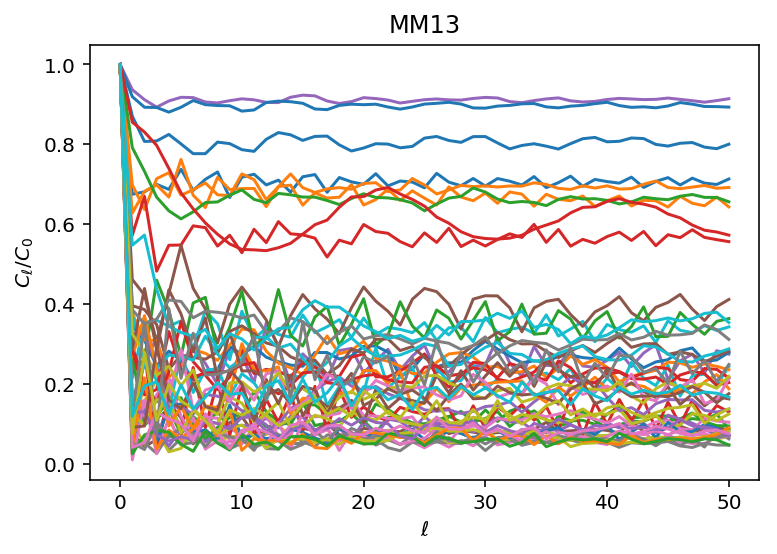

In [21]:
fig, ax = plt.subplots()
mm_store_ani_sig = []
for i in range(len(mm_sig_ani_vec)):
    Cl_all = mm_sig_ani_vec[i]
    norm = Cl_all[0]
    mm_store_ani_sig.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("plots_anisotropy/KH13_all_ani_curves_l50_87.pdf")
print(mm_sig_ani_vec)

Text(0,0.5,'$C_\\ell/C_0$')

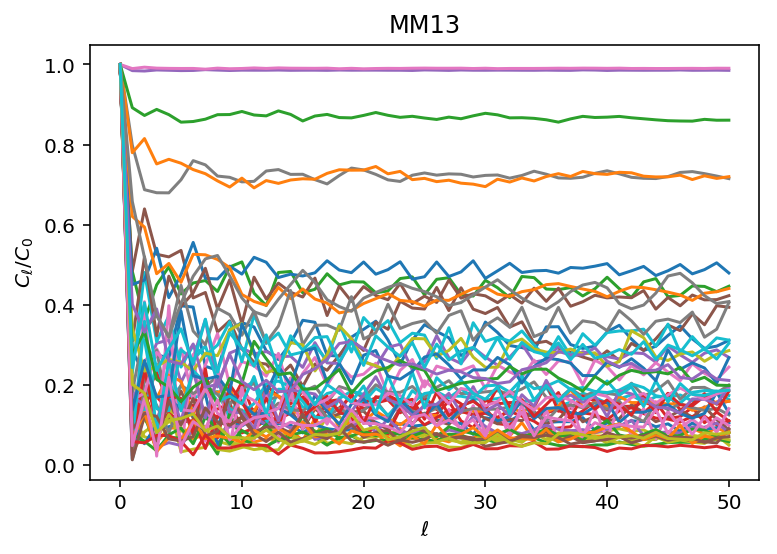

In [22]:
fig, ax = plt.subplots()
kh_store_ani_sig = []
for i in range(len(kh_sig_ani_vec)):
    Cl_all = kh_sig_ani_vec[i]
    norm = Cl_all[0]
    kh_store_ani_sig.append(Cl_all/norm)
    ax.plot(np.arange(0,lmax+1),Cl_all/norm)
plt.title("MM13")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")

In [ ]:
# Can we make an average/median sky map? Would be interesting!

In [19]:
mm_ani_vec = np.array(mm_ani_vec)
kh_ani_vec29 = np.array(kh_ani_vec29)
hr_ani_vec = np.array(hr_ani_vec)

In [ ]:
mm_ani_vec_51 = np.array(mm_ani_vec_51)
mm_ani_vec_68 = np.array(mm_ani_vec_68)
mm_ani_vec_102 = np.array(mm_ani_vec_102)

In [23]:
kh_ani_vec87 = np.array(kh_ani_vec87)
kh_ani_vec58 = np.array(kh_ani_vec58)
kh_ani_vec435 = np.array(kh_ani_vec435)
kh_ani_vec29 = np.array(kh_ani_vec29)

In [23]:
kh_sig_ani_vec = np.array(kh_sig_ani_vec)
mm_sig_ani_vec = np.array(mm_sig_ani_vec)

kh_ani_vec29 = np.array(kh_ani_vec29)
mm_ani_vec = np.array(mm_ani_vec)

In [20]:
mmdata = np.array(mm_store_ani)
mm_avg_ani = np.average(mmdata, axis=0)
mm_med_ani = np.median(mmdata, axis=0)

khdata = np.array(kh_store_ani29)
kh_avg_ani = np.average(khdata, axis=0)
kh_med_ani = np.median(khdata, axis=0)

hrdata = np.array(hr_store_ani)
hr_avg_ani = np.average(hrdata, axis=0)
hr_med_ani = np.median(hrdata, axis=0)

In [24]:
mmdata = np.array(mm_store_ani)
mm_avg_ani = np.average(mmdata, axis=0)
mm_med_ani = np.median(mmdata, axis=0)

khdata29 = np.array(kh_store_ani29)
kh_avg_ani_29 = np.average(khdata29, axis=0)
kh_med_ani_29 = np.median(khdata29, axis=0)

In [ ]:
mmdata51 = np.array(mm_store_ani_51)
mm_avg_ani_51 = np.average(mmdata51, axis=0)
mm_med_ani_51 = np.median(mmdata51, axis=0)

mmdata68 = np.array(mm_store_ani_68)
mm_avg_ani_68 = np.average(mmdata68, axis=0)
mm_med_ani_68 = np.median(mmdata68, axis=0)

mmdata102 = np.array(mm_store_ani_102)
mm_avg_ani_102 = np.average(mmdata102, axis=0)
mm_med_ani_102 = np.median(mmdata102, axis=0)

In [24]:
khdata29 = np.array(kh_store_ani29)
kh_avg_ani_29 = np.average(khdata29, axis=0)
kh_med_ani_29 = np.median(khdata29, axis=0)

khdata435 = np.array(kh_store_ani435)
kh_avg_ani_435 = np.average(khdata435, axis=0)
kh_med_ani_435 = np.median(khdata435, axis=0)

khdata58 = np.array(kh_store_ani58)
kh_avg_ani_58 = np.average(khdata58, axis=0)
kh_med_ani_58 = np.median(khdata58, axis=0)

khdata87 = np.array(kh_store_ani87)
kh_avg_ani_87 = np.average(khdata87, axis=0)
kh_med_ani_87 = np.median(khdata87, axis=0)


In [28]:
mmsigdata = np.array(mm_store_ani_sig)
mmsig_avg = np.average(mmsigdata, axis = 0)
mmsig_med = np.average(mmsigdata, axis = 0)

khsigdata = np.array(kh_store_ani_sig)
khsig_avg = np.average(khsigdata, axis = 0)
khsig_med = np.average(khsigdata, axis = 0)

In [34]:
print(mm_avg_ani)
print(kh_avg_ani)
print(hr_avg_ani)

[1.         0.15937837 0.17172259 0.15106657 0.16811469 0.16053888
 0.16029201 0.15599214 0.16189372 0.16122715 0.15765127 0.16227891
 0.15691662 0.1640706  0.15962463 0.15580731 0.1565454  0.15841864
 0.16283878 0.16067578 0.16399139 0.16004412 0.16031821 0.15684491
 0.15840148 0.16313944 0.16107354 0.16441835 0.15933417 0.15825943
 0.15792325 0.15560891 0.15960579 0.16333843 0.16337558 0.15699352
 0.15985065 0.16065656 0.15968635 0.16171209 0.15966629 0.16062303
 0.1604475  0.15758157 0.15840348 0.15802849 0.16470306 0.16036551
 0.16053946 0.15441756 0.15859856]
[1.         0.31886898 0.31962477 0.32623848 0.33086757 0.35542951
 0.33768627 0.31931394 0.33289111 0.32996671 0.32749962 0.32065954
 0.31627745 0.33744886 0.33799499 0.3296236  0.32963404 0.32689997
 0.33782532 0.33059735 0.32898845 0.33217613 0.32924954 0.33532017
 0.33219555 0.32972779 0.31924556 0.33045707 0.33034329 0.33285439
 0.32786935 0.3278212  0.3313496  0.33359888 0.33353691 0.33629455
 0.33044953 0.33485939 0.33

In [ ]:
plt.plot(kh_avg_ani, label = "KH13", color = "C0")
plt.plot(mm_avg_ani, label = "MM13", color = "C1")
plt.plot(hr_avg_ani, label = "HR04", color = "C2")

plt.legend(frameon=False)

plt.xlim(0,40)

plt.title("Average GWB anisotropy")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("avg_of_all_skies.png")
plt.savefig("plots_comparison/avg_of_all_skies_mor.pdf")



In [ ]:
print(np.average(mm_avg_ani))
print(np.average(kh_avg_ani))
print(np.average(hr_avg_ani))

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


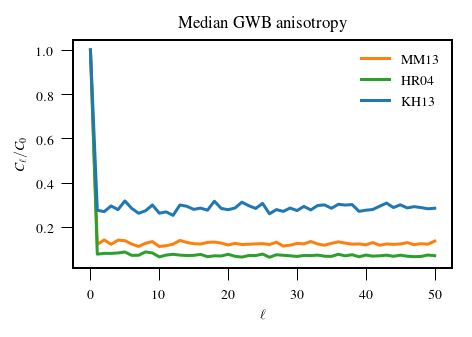

In [25]:
plt.plot(mm_med_ani, label = "MM13", color = "C1")
plt.plot(hr_med_ani, label = "HR04",  color = "C2")
plt.plot(kh_med_ani, label = "KH13",  color = "C0")

plt.legend(frameon=False)

plt.title("Median GWB anisotropy")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("median_of_all_skies.png")
plt.savefig("../../../../../median_of_all_skies.pdf")



In [22]:
print(np.average(mm_med_ani))
print(np.average(kh_med_ani))
print(np.average(hr_med_ani))

0.1420750531476862
0.29988841656783943
0.09018635107635292


In [ ]:

plt.plot(mm_med_ani, label = "MM13 0.34 dex")
plt.plot(mm_med_ani_51, label = "MM13 0.51 dex")
plt.plot(mm_med_ani_68, label = "MM13 0.68 dex")
plt.plot(mm_med_ani_102, label = "MM13 1.02 dex")
plt.legend(frameon=False)

plt.title("Median GWB anisotropy")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("median_of_all_skies.png")
plt.savefig("../plots/dex_median_of_all_skies.pdf")




/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


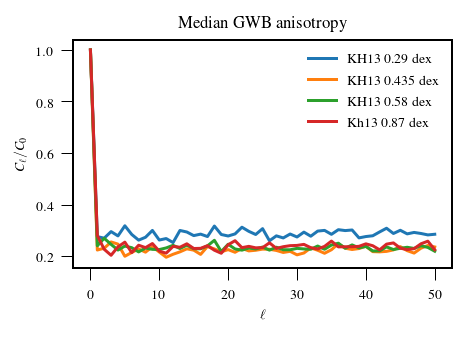

In [27]:
plt.plot(kh_med_ani_29, label = "KH13 0.29 dex")
plt.plot(kh_med_ani_435, label = "KH13 0.435 dex")
plt.plot(kh_med_ani_58, label = "KH13 0.58 dex")
plt.plot(kh_med_ani_87, label = "Kh13 0.87 dex")
plt.legend(frameon=False)

plt.title("Median GWB anisotropy")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("median_of_all_skies.png")
plt.savefig("plots_comparison/kh13_dex_median_of_all_skies.pdf")




Text(0,0.5,'$C_\\ell/C_0$')

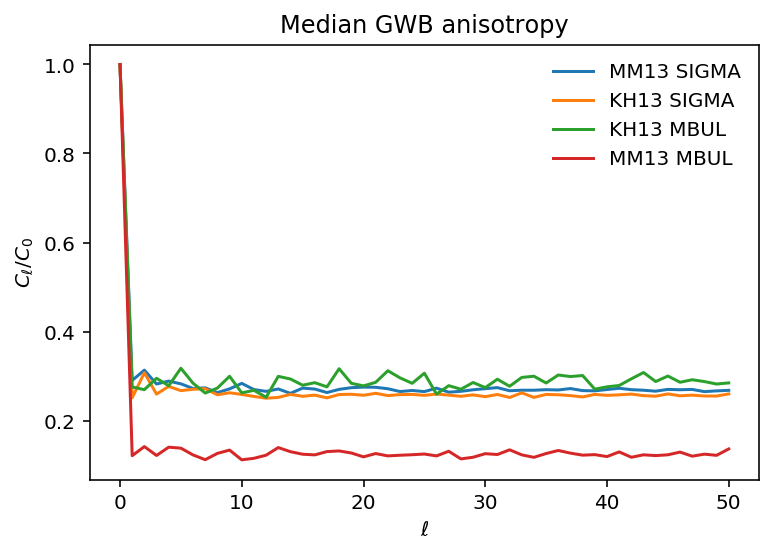

In [32]:
plt.plot(mmsig_med, label = "MM13 SIGMA")
plt.plot(khsig_med, label = "KH13 SIGMA")
plt.plot(kh_med_ani_29, label = "KH13 MBUL")
plt.plot(mm_med_ani, label = "MM13 MBUL")
plt.legend(frameon=False)

plt.title("Median GWB anisotropy")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell/C_0$")
#plt.savefig("plots_comparison/kh13_dex_median_of_all_skies.pdf")




In [30]:
print("0.34 = ", np.average(mm_med_ani))
print("0.51 = ", np.average(mm_med_ani_51))
print("0.68 = ", np.average(mm_med_ani_68))
print("1.02 = ", np.average(mm_med_ani_102))

0.34 =  0.1420750531476862


NameError: name 'mm_med_ani_51' is not defined

In [31]:
print("0.29 = ", np.average(kh_med_ani_29))
print("0.435 = ", np.average(kh_med_ani_435))
print("0.58 = ", np.average(kh_med_ani_58))
print("0.87 = ", np.average(kh_med_ani_87))

0.29 =  0.29988841656783943


NameError: name 'kh_med_ani_435' is not defined

In [ ]:
avg = [np.average(mm_med_ani), np.average(mm_med_ani_51), np.average(mm_med_ani_68), np.average(mm_med_ani_102)]
dex = [0.34, 0.51, 0.68, 1.02]

plt.scatter(avg, dex)

"""doesnt affect anisptrpy """